# Import the packages

In [1]:
import numpy as np
import os
import re
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import tifffile
from tqdm import tqdm
import glob
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn
import torchvision.models as models 
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sh30iap3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sh30iap3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


# Set the parameters of the SAM model

In [2]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "/kaggle/input/sam-model/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=15,
    points_per_batch=15,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.8,
    crop_n_layers=0,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

mask_generator2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    points_per_batch=5,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.8,
    crop_n_layers=0,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


#　Adjust the parameters of the cell segmentation model
Set weights for different channels (fluorescence or brightfield) in the TIFF images to achieve better segmentation results. Parameters can be iteratively adjusted based on the segmentation outcomes.

[1.9617224880382775, 1.9617224880382775, 2.0]
[725, 719, 560]


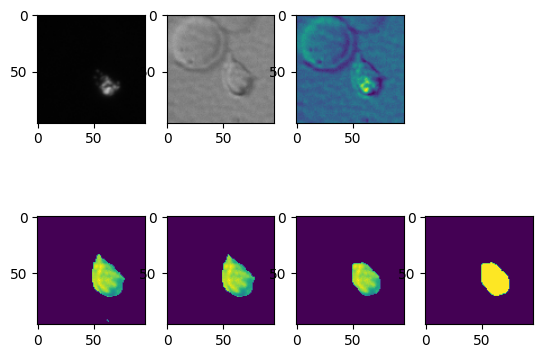

In [3]:
image = tifffile.imread("/examples/Polarization Index/MPD 013-1.tif")
a = 0.3                                                                                                                       # Set weights for different channels 
b = 0.7                                                                                                                       # Set weights for different channels
#c = 0.1
image_c1 = np.uint8(a*image[0]+b*image[1])                                                                                    # Generate a 3-channel image for segmentation
image_c1_3 = cv2.cvtColor(image_c1, cv2.COLOR_GRAY2RGB)

masks = mask_generator.generate(image_c1_3)                                                                                   # Start to segmentation
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)                                                                # Sort the segmentation results in descending order by area
target_channel = image[0]
new = target_channel.mean()*(target_channel-target_channel.min())/(target_channel.max()-target_channel.min())                 # Standardized and normalized fluorescence channel pixels are used as the standard for further screening of segmentation results
masks_list = []
avg_list = []
area_list = []
for i in masks:                                                                                                               # Screen out segmentation results that do not meet the criteria by area
    if (400 < i["area"] < 1800):
        multiply = np.uint8(new*i["segmentation"])
        avg = abs(multiply.sum()/(multiply>0).sum())
        if 0 <= avg :                                                                                                         # Screen out segmentation results that do not meet the criteria by fluorescence intensity (optional)
            avg_list.append(avg)
            area_list.append(i["area"])
            masks_list.append(i["segmentation"])
print(avg_list)
print(area_list)
index = avg_list.index(max(avg_list))
n = len(masks_list)

if n > 2:
    plt.subplot(2,n+1,1)
    plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_GRAY2RGB))
    plt.subplot(2,n+1,2)
    plt.imshow(cv2.cvtColor(image[1], cv2.COLOR_GRAY2RGB))
    plt.subplot(2,n+1,3)
    plt.imshow(image_c1)
    for i in range(n):
        plt.subplot(2,n+1,n+2+i)
        plt.imshow(masks_list[i]*image[1])
    plt.subplot(2,n+1,2*n+2)
    plt.imshow(np.uint8(masks_list[index]))
    plt.show()
    
elif 0 < n < 3:
    plt.subplot(2,4,1)
    plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_GRAY2RGB))
    plt.subplot(2,4,2)
    plt.imshow(cv2.cvtColor(image[1], cv2.COLOR_GRAY2RGB))
    plt.subplot(2,4,3)
    plt.imshow(image_c1)
    for i in range(n):
        plt.subplot(2,4,5+i)
        plt.imshow(masks_list[i]*image[1])
    plt.subplot(2,4,5+n)
    plt.imshow(np.uint8(masks_list[index]))
    plt.show()

# Batch Segmentation

In [4]:
filepath_list = glob.glob("/examples/20241017 0714 CROP analyze polarity/*.tif")
filedir_list = [(str(Path(i).parts[-2]).split(".")[0]).replace(" ","-") for i in filepath_list]
filename_list = [str(Path(i).parts[-1]).split(".")[0] for i in filepath_list]

for i in tqdm(range(0,len(filepath_list))):
    image_stack = tifffile.imread(filepath_list[i])
    a = 0.3
    b = 0.7
    image = np.uint8(a*image_stack[0]+b*image_stack[1])
    image_3 = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    target_channel = image_stack[0]
    new = target_channel.mean()*(target_channel-target_channel.min())/(target_channel.max()-target_channel.min())
    masks = mask_generator.generate(image_3)
    masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    avg_list = []
    masks_list = []
    for j in masks:
        if 400 < j["area"] < 1800:
            multiply = np.uint8(new*j["segmentation"])
            avg = abs(multiply.sum()/(multiply>0).sum())
            if 0 <= avg:
                avg_list.append(avg)
                masks_list.append(j["segmentation"])                                                                
    if len(masks_list) > 0:
        index = avg_list.index(max(avg_list))
        tifffile.imwrite("{}.tif".format(filename_list[i]),np.uint8(np.where(masks_list[index]>0,100,0)),append=True)        # Generate masks for cells
        tifffile.imwrite("{}.tif".format(filename_list[i]),np.uint8(image_stack[0]),append=True)                             
        tifffile.imwrite("{}.tif".format(filename_list[i]),np.uint8(image_stack[1]),append=True)

  9%|▉         | 3/34 [00:05<00:54,  1.77s/it]<ipython-input-4-05713e810ef0>:21: RuntimeWarning: invalid value encountered in divide
  avg = abs(multiply.sum()/(multiply>0).sum())
100%|██████████| 34/34 [00:59<00:00,  1.76s/it]
